# `01` Chest CT Data
- Design your own U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$
- Use a generator to load the images
(**Hint:** You can use `tensorflow.keras.utils.image_dataset_from_directory`)
- Use 85% of the provided data for training and 15% for validation.
- Use $32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `+` Import Libraries

In [62]:
import gdown
import os
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory
from keras.layers import Conv2DTranspose, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, MaxPool2D, Rescaling, Conv2D, Dense, RandomFlip, RandomRotation
from tensorflow.keras.applications import InceptionV3, ResNet50

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [2]:
gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=9e06372b-b7b4-4de8-bd41-1670244746da
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:01<00:00, 35.6MB/s]


'Lung_Data.zip'

In [3]:
%%capture
!unzip Lung_Data.zip

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

# `+` Seed Value

In [4]:
SEED = 907

## `+` Set Global Parameters

In [5]:
# Hyperparameters
BATCH_SIZE = 8
EPOCHS = 20

In [6]:
folders = ['grey', 'mask']
for folder in folders:
    out_dir = f'Lung_Data_PNG/{folder}'
    os.makedirs(out_dir, exist_ok=True)
    for img in glob(f'Lung_Data/{folder}/*.bmp'):
        Image.open(img).save(os.path.join(out_dir, img.split('/')[-1].rsplit('.', maxsplit=1)[0] + '.png'), 'PNG')

In [7]:
# Training Dataset
grey_train_ds, grey_val_ds = image_dataset_from_directory('Lung_Data_PNG/grey',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="both")

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


In [8]:
# Validation Dataset
mask_train_ds, mask_val_ds = image_dataset_from_directory('Lung_Data_PNG/mask',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="both")

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


### Preview the Images

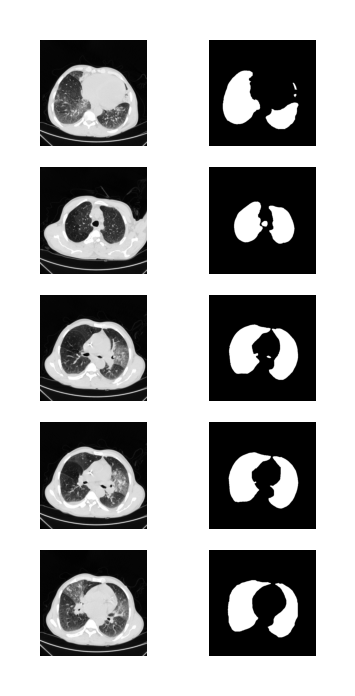

In [9]:
# Preview Images
plt.figure(figsize=(1, 2), dpi=400)
for images, masks in zip(grey_train_ds.take(4), mask_train_ds.take(4)):
    for i in range(5):
        plt.subplot(5, 2, i*2+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.subplot(5, 2, i*2+2)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')

# `i` Model Design

## Building U-Net from Scratch

### Define Building Blocks

In [10]:
def double_conv(x, n_filters):
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    return x

In [11]:
def downsample_block(x, n_filters):
    f = double_conv(x, n_filters)
    p = MaxPool2D()(f)
    return f, p

In [12]:
def upsample_block(x, n_filters, skip_features):
    x = Conv2DTranspose(n_filters, (3, 3), 2, padding='same')(x)
    x = Concatenate()([x, skip_features])
    x = double_conv(x, n_filters)
    return x

### Build Model Structure

In [13]:
inputs = Input((512, 512, 1))

# Rescaling
scaled_inputs = Rescaling(1./255)(inputs)

# Encoder
f1, p1 = downsample_block(scaled_inputs, 32)
f2, p2 = downsample_block(p1, 64)
f3, p3 = downsample_block(p2, 128)
f4, p4 = downsample_block(p3, 256)


# Bottleneck
bottleneck = double_conv(p4, 512)

# Decoder
u4 = upsample_block(bottleneck, 256, f4)
u3 = upsample_block(u4, 128, f3)
u2 = upsample_block(u3, 64, f2)
u1 = upsample_block(u2, 32, f1)


# Output (Mask)
outputs = Conv2D(1, (1,1), activation='sigmoid', padding='same')(u1)

model = Model(inputs, outputs, name='UNet_Model')

model.summary()

Model: "UNet_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  1,179,904 │ conv2d_9[0][0]  

 Total params: 8,629,921 (32.92 MB)

 Trainable params: 8,629,921 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

## `ii` Model Compilation & Training

In [14]:
model.compile(keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
segment_train = tf.data.Dataset.zip(grey_train_ds, mask_train_ds.map(lambda x: Rescaling(1./255)(x)))
segment_val = tf.data.Dataset.zip(grey_val_ds, mask_val_ds.map(lambda x: Rescaling(1./255)(x)))

In [16]:
history = model.fit(
    x=segment_train,
    epochs=EPOCHS,
    validation_data=segment_val,
    steps_per_epoch=grey_train_ds.cardinality().numpy(),
    validation_steps=grey_val_ds.cardinality().numpy()
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8864 - loss: 0.4298 - val_accuracy: 0.8835 - val_loss: 0.4078
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 660ms/step - accuracy: 0.8933 - loss: 0.3890 - val_accuracy: 0.8835 - val_loss: 0.3842
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 654ms/step - accuracy: 0.8927 - loss: 0.3691 - val_accuracy: 0.8835 - val_loss: 0.3666
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 672ms/step - accuracy: 0.8947 - loss: 0.3627 - val_accuracy: 0.8835 - val_loss: 0.3407
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 648ms/step - accuracy: 0.8939 - loss: 0.2999 - val_accuracy: 0.8835 - val_loss: 0.2446
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 643ms/step - accuracy: 0.8903 - loss: 0.2329 - val_accuracy: 0.8835 - val_loss: 0.2202
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 622ms/step - accuracy: 0.8916 - loss: 0.2057 - val_accuracy: 0.9255 - val_loss: 0.1591
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 645ms/step - accuracy: 0.9364 - loss: 0.1659 - val_accurac

## `iii` Model Evaluation

In [17]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [18]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(segment_train)
print(f"Accuracy for training: {train_accuracy * 100:.2f}")

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(segment_val)
print(f"Accuracy for testing: {test_accuracy * 100:.2f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.9915 - loss: 0.0251
Accuracy for training: 99.15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.9906 - loss: 0.0275
Accuracy for testing: 99.13


## `iv` Result Visualization

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

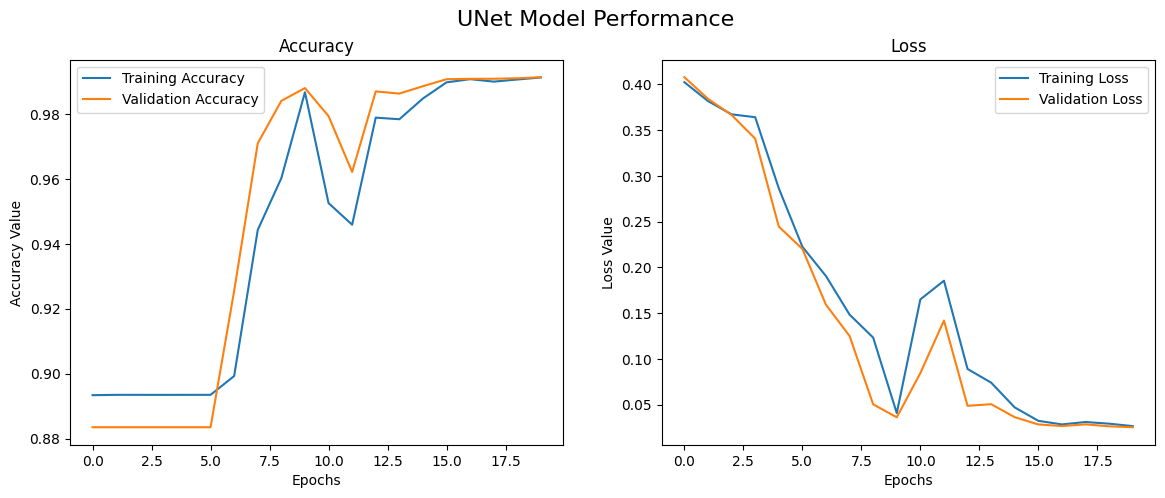

In [20]:
# Plot the training and validation accuracy and loss

fig = plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.legend()


# Loss plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

fig.suptitle('UNet Model Performance', fontsize=16)

plt.show()

## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [21]:
preds = model.predict(list(grey_val_ds.take(3))[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


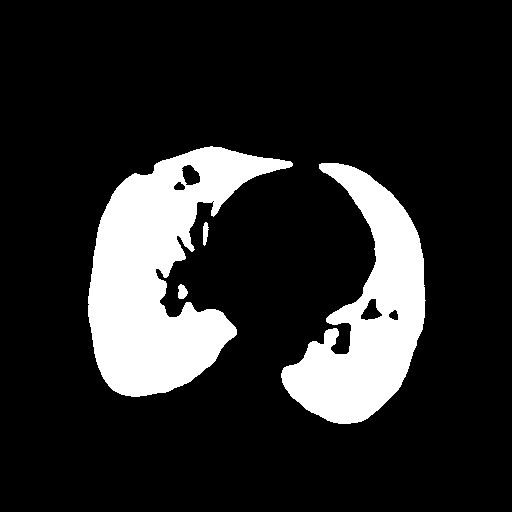

In [22]:
keras.utils.array_to_img(preds[0] > 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


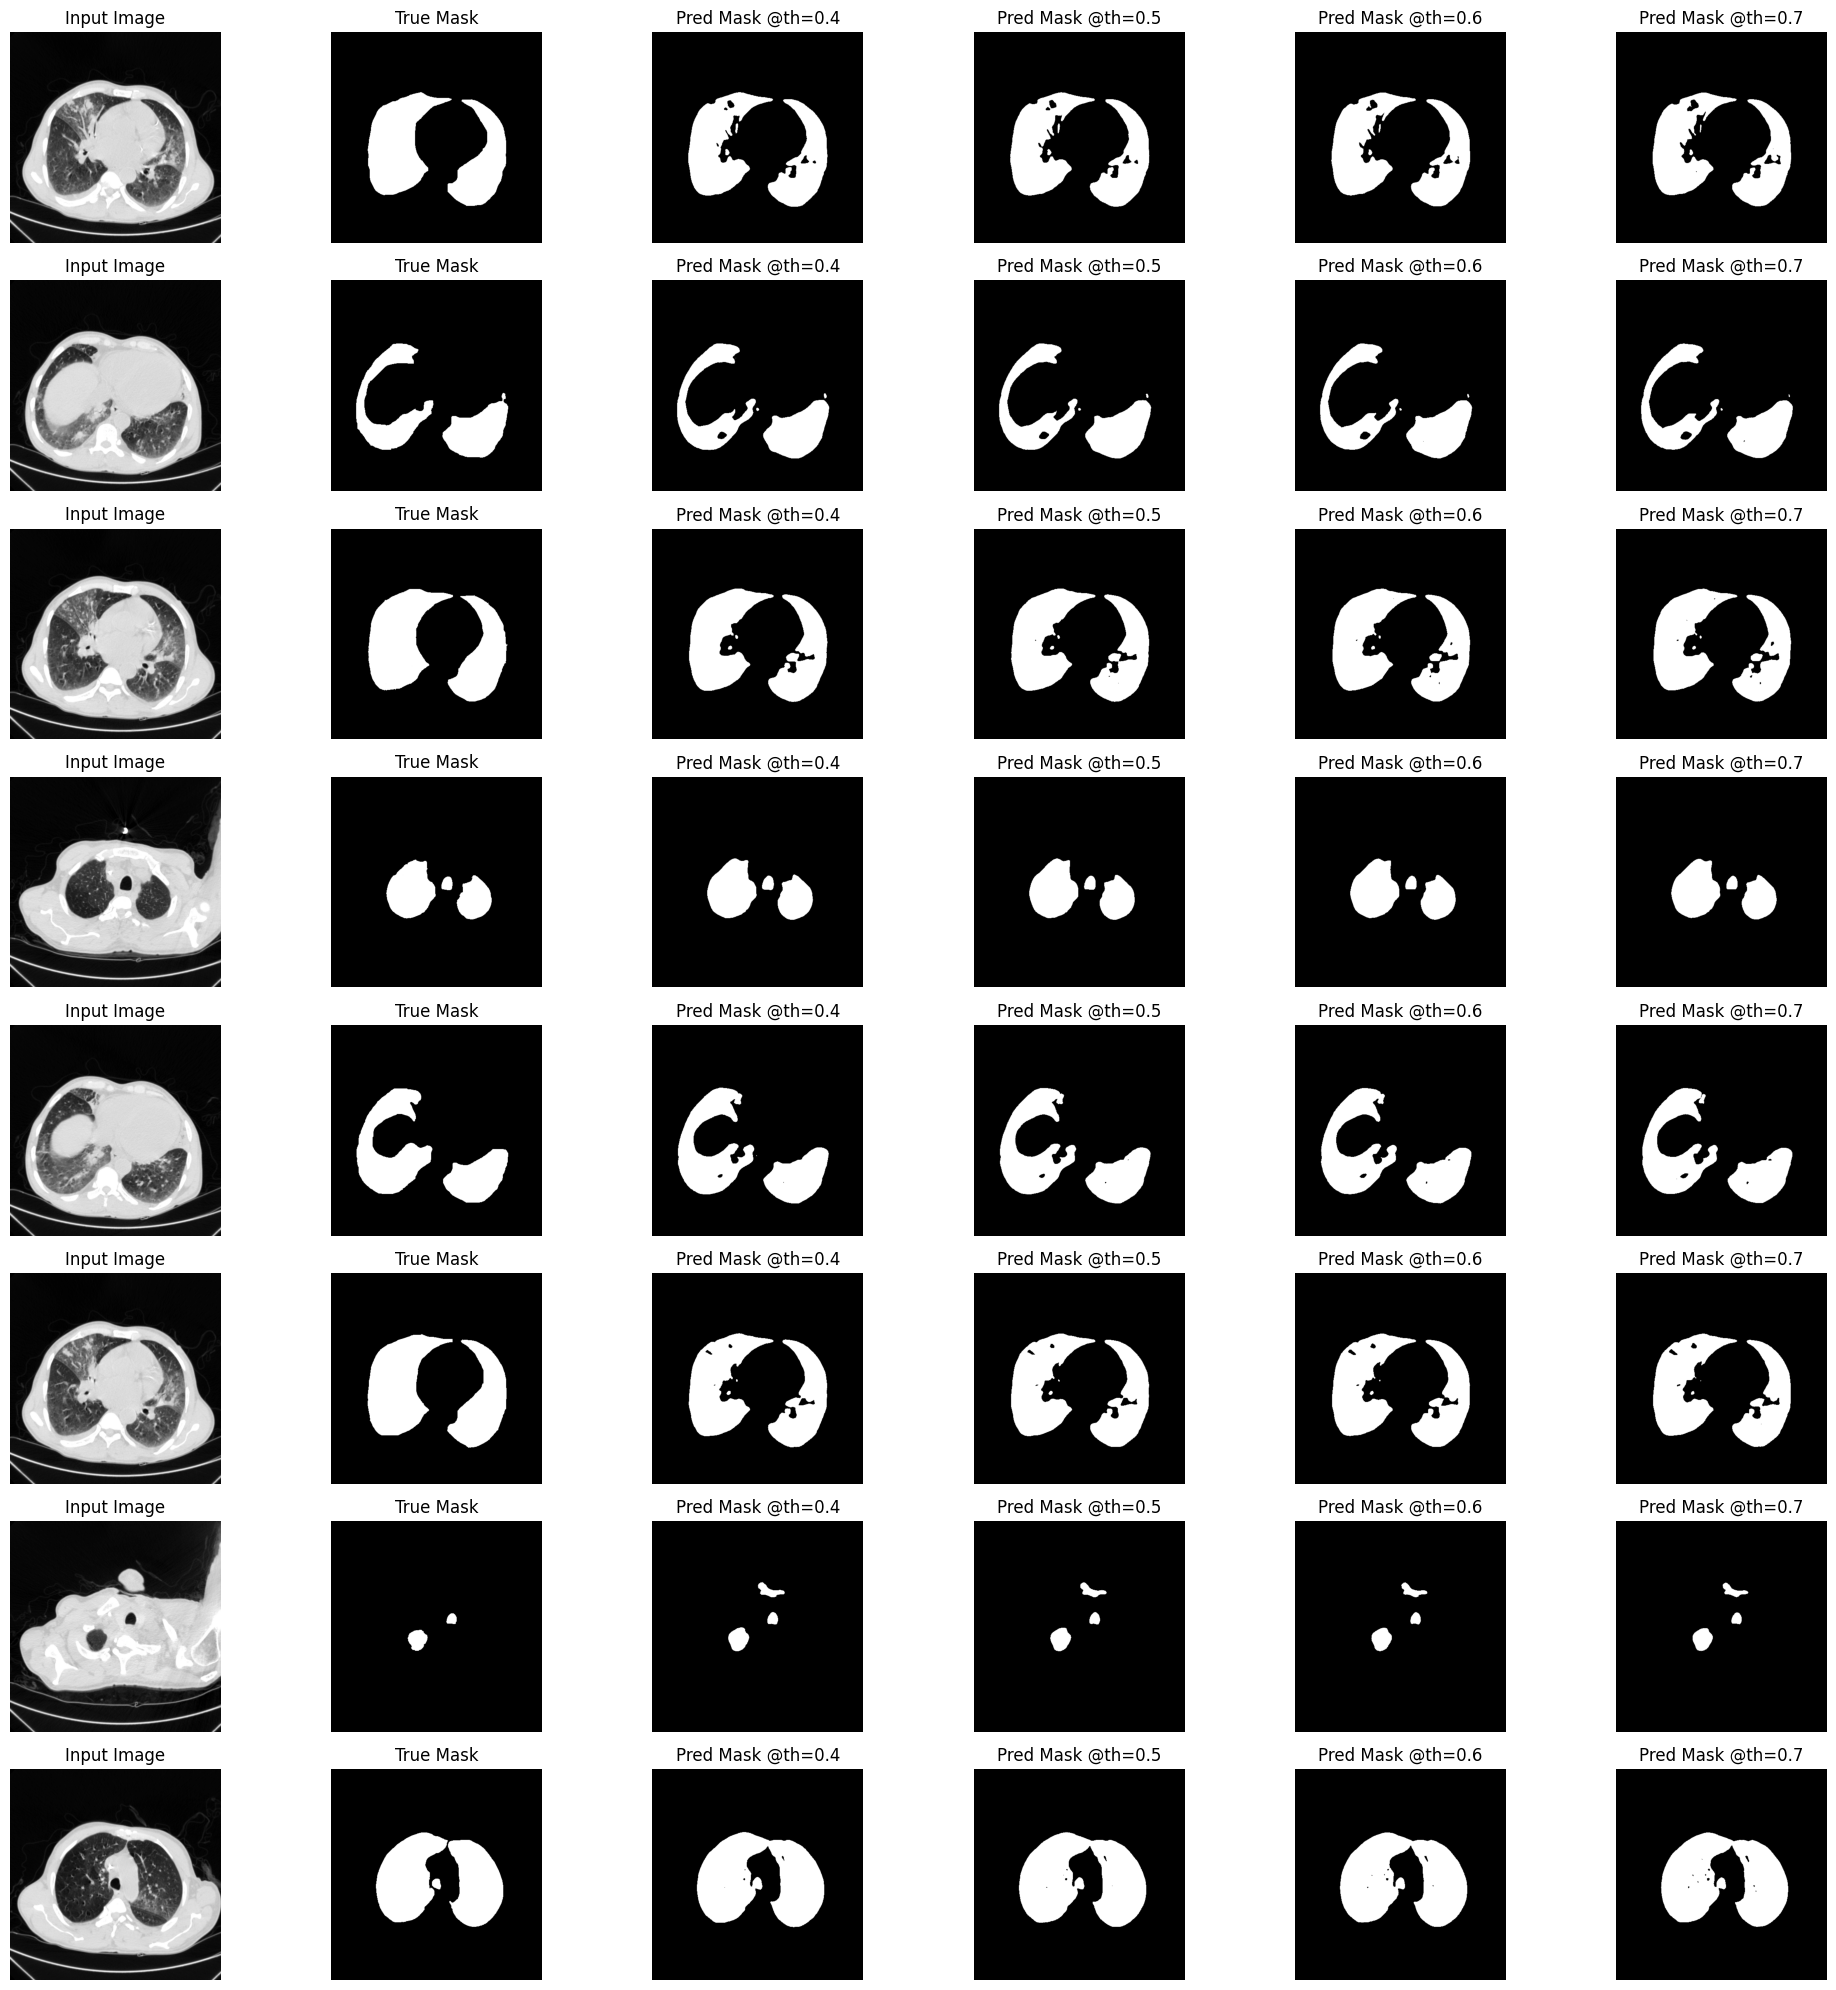

In [23]:
input_images, true_masks = next(iter(segment_val.take(1)))

pred_masks = model.predict(input_images)


thresholds = [0.4, 0.5, 0.6, 0.7]

plt.figure(figsize=(20, 20))

for i in range(8):
    input_img = tf.squeeze(input_images[i])
    true_mask = tf.squeeze(true_masks[i])
    pred_mask = pred_masks[i].squeeze()

    # Input Image
    plt.subplot(8, 6, i * 6 + 1)
    plt.imshow(input_img, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    # True Mask
    plt.subplot(8, 6, i * 6 + 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    # Predicted Masks @ different thresholds
    for j, th in enumerate(thresholds):
        bin_mask = (pred_mask > th).astype(np.uint8)
        plt.subplot(8, 6, i * 6 + 3 + j)
        plt.imshow(bin_mask, cmap='gray')
        plt.title(f"Pred Mask @th={th}")
        plt.axis('off')

plt.tight_layout()
plt.show()


**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.

------------------------------

# Cats & Dogs Data
- Design your Deep Convolutional Neural Network using `Transfer Learning`
- You can select any pretrained model as a base and build on top.
- The task is to successfully classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).
- There are no constraint; you have **full power**.

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [24]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   108M      0  0:00:07  0:00:07 --:--:-- 58.3M


In [25]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

PetImages/Cat  PetImages/Dog


In [26]:
# Delete Corrupted Images

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


## `+` Set Global Parameters

In [27]:
# Hyperparameters
BATCH_SIZE = 10
EPOCHS = 20

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [28]:
# Training/Validation Dataset
train_ds, val_ds = image_dataset_from_directory('PetImages',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(180,180),
                                                validation_split=0.2,
                                                subset="both")

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


### Preview the Images

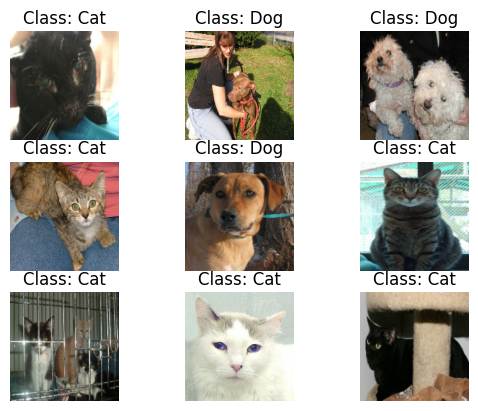

In [29]:
# Preview Images
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(f'Class: {["Cat", "Dog"][labels[i]]}')
    plt.axis('off')

## `i` Model Design

In [30]:
pre_trained = ResNet50(include_top=False, pooling='avg', weights='imagenet')
for layer in pre_trained.layers:
  layer.trainable = False
pre_trained.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [31]:
model = Sequential()
model.add(Input((180, 180, 3)))
model.add(RandomFlip())
model.add(RandomRotation(0.2))
model.add(pre_trained)
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## `ii` Model Compilation & Training

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    steps_per_epoch=train_ds.cardinality().numpy(),
                    validation_steps=val_ds.cardinality().numpy())

Epoch 1/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 107s 51ms/step - accuracy: 0.8533 - loss: 0.3182 - val_accuracy: 0.9361 - val_loss: 0.1558
Epoch 2/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 94s 50ms/step - accuracy: 0.9025 - loss: 0.2324 - val_accuracy: 0.9611 - val_loss: 0.0929
Epoch 3/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 94s 50ms/step - accuracy: 0.9093 - loss: 0.2188 - val_accuracy: 0.9601 - val_loss: 0.0984
Epoch 4/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 96s 51ms/step - accuracy: 0.9159 - loss: 0.2040 - val_accuracy: 0.9590 - val_loss: 0.1010
Epoch 5/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 141s 51ms/step - accuracy: 0.9134 - loss: 0.2109 - val_accuracy: 0.9564 - val_loss: 0.1059
Epoch 6/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 142s 50ms/step - accuracy: 0.9228 - loss: 0.1979 - val_accuracy: 0.9637 - val_loss: 0.0945
Epoch 7/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 91s 49ms/step - accuracy: 0.9170 - loss: 0.2029 - val_accuracy: 0.9588 - val_loss: 0.0987
Epoch 8/20
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 140s 48ms/step - accuracy: 0.92

## `iii` Model Evaluation

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [35]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Accuracy for training: {train_accuracy * 100:.2f}")

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Accuracy for testing: {test_accuracy * 100:.2f}")


1873/1873 ━━━━━━━━━━━━━━━━━━━━ 67s 36ms/step - accuracy: 0.9514 - loss: 0.1306
Accuracy for training: 95.47
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9457 - loss: 0.1475
Accuracy for testing: 94.53


## `iv` Result Visualization

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

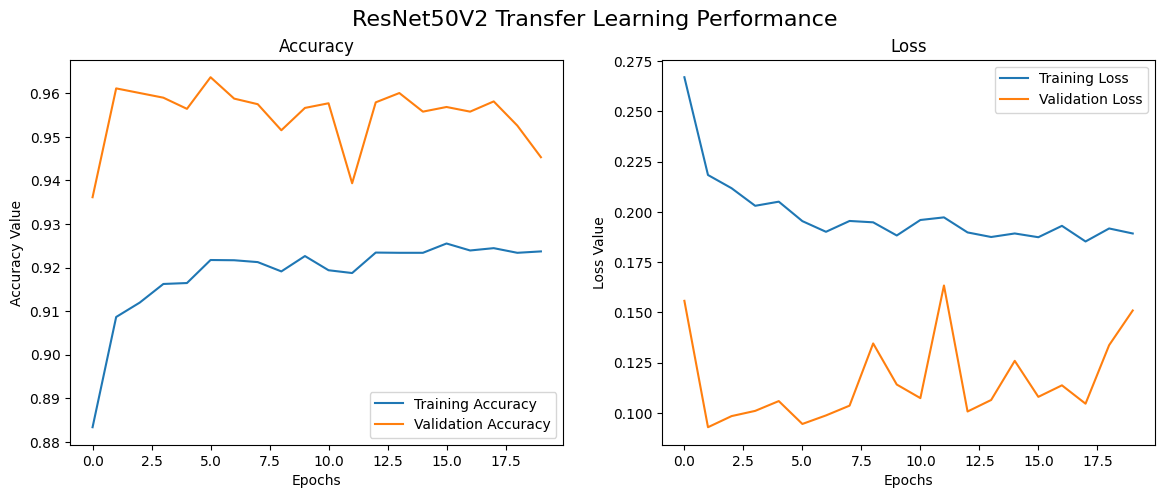

In [37]:
# Plot the training and validation accuracy and loss
fig = plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.legend()


# Loss plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

fig.suptitle('ResNet50V2 Transfer Learning Performance', fontsize=16)

plt.show()

## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.

Also, try to classify an image from the internet.

**Note:** remember to properly process the image (dimensions, rescaling, etc.)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


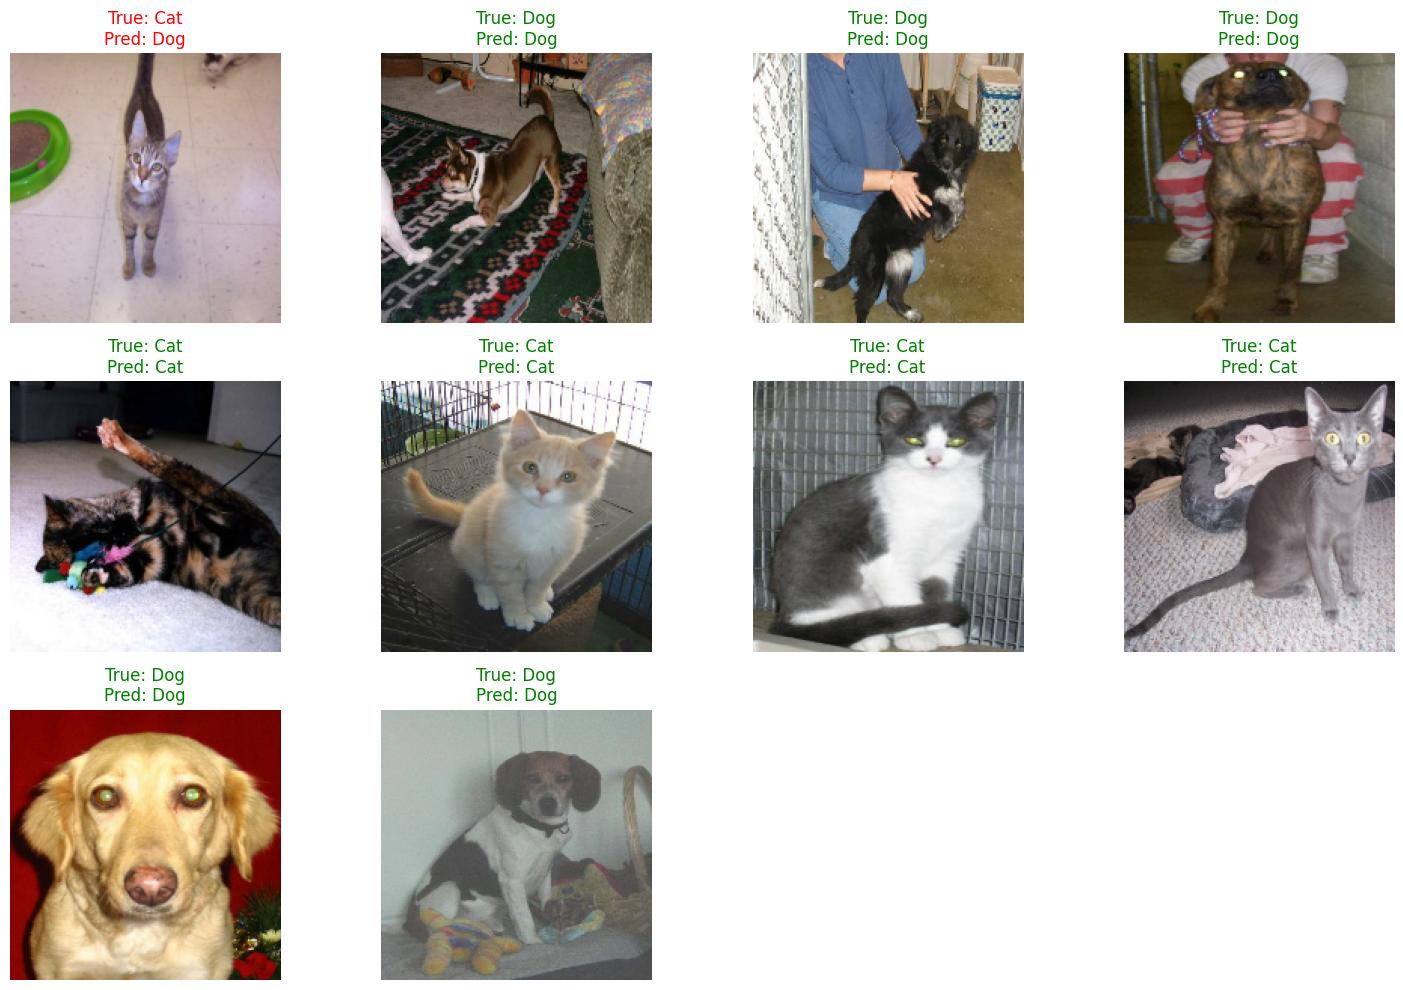

In [53]:
# Plot the Input, True Label, and Predicted Label

class_names = train_ds.class_names

val_images, val_labels = next(iter(val_ds.take(1)))

pred_probs = model.predict(val_images)

pred_labels = (pred_probs > 0.5).astype("int32").flatten()

num_images = val_images.shape[0]

plt.figure(figsize=(15, 10))
for i in range(num_images):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(val_images[i].numpy().astype("uint8"))

    true_label = class_names[val_labels[i]]
    pred_label = class_names[pred_labels[i]]

    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Classify an image from the internet

In [54]:
# Function to preprocess an image
def preprocess_image(img_path):
    img = Image.open(img_path).resize((180, 180))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


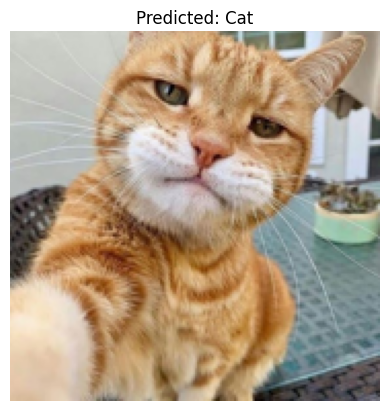

In [61]:
# Classify an image
image = "/content/cat.jpeg"

try:
    # Use open() to read local file
    image = Image.open(image)
    image = image.resize((180, 180))
    img_array = np.array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    plt.imshow(image)
    plt.title(f"Predicted: {['Cat', 'Dog'][predicted_class]}")
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Error: Image file not found at {image}")
except Exception as e:
    print(f"An error occurred: {e}")

----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
